In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/activity-of-zebrafish/gandhi_et_al_bouts.csv


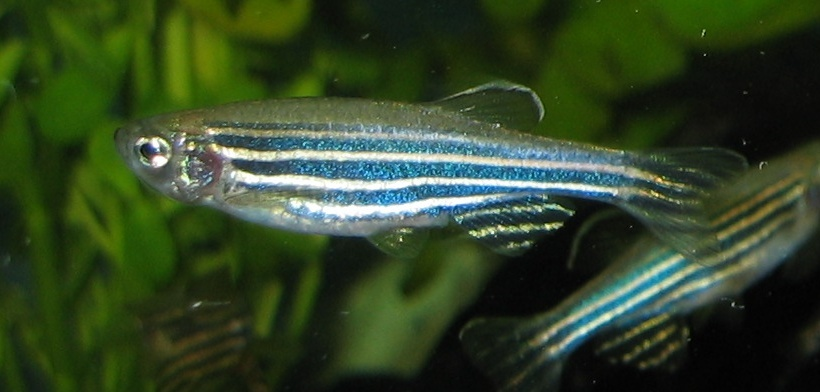

**Melatonin** is part of the evolutionary conserved highly functional network in vertebrates. It plays a central role in the adaptative behavior of the animal to the environment, including entrainment of daily and annual physiological rhythms, reproductive behavior, food intake, locomotor activity, growth, and breeding performance. In zebrafish, apart from its synchronizing capabilities, melatonin seems to have a major role in multiple physiological processes. Extensive knowledge of its genome and the identification of a series of genes with the same functions as those in humans, the relative ease of obtaining mutants, and the similarities between zebrafish and human pathologies make it an excellent experimental model organism of human diseases. Moreover, it is a common experimental species because of easy handling, breeding, and developmental control. Among other pathophysiologies, zebrafish are now used in studies of neurodegeneration and neurological diseases, endocrine diseases, behavior, muscular dystrophies, developmental alterations, circadian rhythms, and drugs screening. The purpose of this review was to update the current knowledge on the synthesis and biological functions of melatonin in zebrafish, keeping in mind its relevance not only in the physiology of the animal, but also in pathophysiological conditions.
https://onlinelibrary.wiley.com/doi/full/10.1111/jpi.12149

Nomenclature
**Mutant:** Has the mutation on both chromosomes
**Wild type:** Does not have the mutation


A metric for wakefulness
* **Active bout:** A period of time where consistently active
* **Active bout length:** Number of consecutive minutes with activity

Genotype definitions
* **Wild type:** No mutations
* **Heterozygote:** Mutation on one of two chromosomes
* **Mutant:** Mutation on both chromosomes

## Target Goal is to quantify the effect of mutation on wakefulness.

In [44]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Data
df = pd.read_csv('/kaggle/input/activity-of-zebrafish/gandhi_et_al_bouts.csv', comment='#')

## Data Validation

In [45]:
df.head(15)

,genotype,bout_length,fish
0,het,12.00,1
1,het,33.00,1
2,het,0.96,1
3,het,4.98,1
4,het,1.98,1
5,het,1.98,1
6,het,4.98,1
7,het,30.00,1
8,het,16.98,1
9,het,22.02,1


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5475 entries, 0 to 5474
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   genotype     5475 non-null   object 
 1   bout_length  5475 non-null   float64
 2   fish         5475 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 128.4+ KB


In [47]:
df.describe()

,bout_length,fish
count,5475.000000,5475.000000
mean,4.810499,49.110685
std,6.578661,27.532831
min,0.960000,1.000000
25%,1.020000,24.000000
50%,3.000000,53.000000
75%,6.000000,74.000000
max,175.980000,96.000000


## EDA
Plotting ECDFs of active bout length. An active bout is a stretch of time where a fish is constantly moving. 

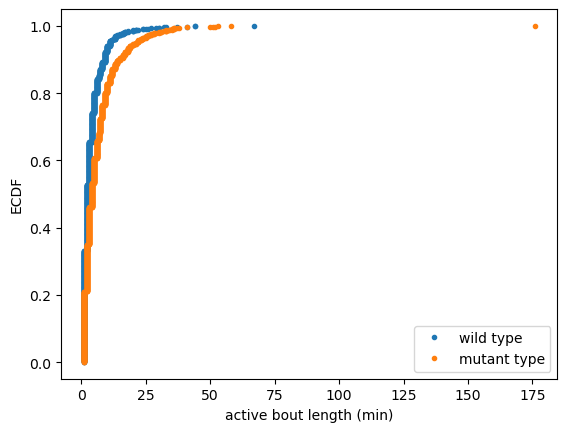

In [48]:
# ECDF function
def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

# Filtering Data
bout_len_wildtype = df['bout_length'][df['genotype'] == 'wt']
bout_len_mutanttype = df['bout_length'][df['genotype'] == 'mut']
bout_len_Heterozygote = df['bout_length'][df['genotype'] == 'het']


# Generate x and y values for plotting ECDFs
x_wild, y_wild = ecdf(bout_len_wildtype)
x_mutant, y_mutant = ecdf(bout_len_mutanttype)

# Plot the ECDFs
plt.plot(x_wild, y_wild, marker='.', linestyle='none')
plt.plot(x_mutant, y_mutant, marker='.', linestyle='none')

# Make a legend, label axes, and show plot
plt.legend(('wild type', 'mutant type'))
plt.xlabel('active bout length (min)')
plt.ylabel('ECDF')
plt.show()

There is outlier on mutant type. bout lengths appear exponentially distributed, which implies that exiting an active bout to rest is a poisson process; the fish have no apparent memory when they became active.

**Poisson process:** The timing of the next event is completely
independent of when the previous event happened

## Bootstrap confidence intervals

In [49]:
# bootstrapping replicates of means
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""
    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)
    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)
    return bs_replicates


# Compute mean active bout length
mean_wildtype = np.mean(bout_len_wildtype)
mean_mutanttype = np.mean(bout_len_mutanttype)

# Draw bootstrap replicates
bs_reps_wt = draw_bs_reps(bout_len_wildtype, np.mean, size=10000)
bs_reps_mut = draw_bs_reps(bout_len_mutanttype, np.mean, size=10000)

# Compute 95% confidence intervals
conf_int_wildtype = np.percentile(bs_reps_wt, [2.5, 97.5])
conf_int_mutanttype = np.percentile(bs_reps_mut, [2.5, 97.5])

# Print the results
print("""
wt:  mean = {0:.3f} min., conf. int. = [{1:.1f}, {2:.1f}] min.
mut: mean = {3:.3f} min., conf. int. = [{4:.1f}, {5:.1f}] min.
""".format(mean_wildtype, *conf_int_wildtype, mean_mutanttype, *conf_int_mutanttype))


wt:  mean = 3.874 min., conf. int. = [3.6, 4.1] min.
mut: mean = 6.543 min., conf. int. = [6.1, 7.0] min.



confidence intervals are quite separated. not ovelapping

## Permutation and bootstrap hypothesis tests

Test the hypothesis that the heterozygote and wild type bout lengths are identically distributed by a permutation test.


In [ ]:
# "permutation test" to do this over and over again to get many permutation replicates.

# Generating a permutation sample
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

# function for permutation replicates
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""
    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)
    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
    return perm_replicates


# Function to calculate ave in 2 arrays
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff =  np.mean(data_1) - np.mean(data_2)

    return diff




# Compute the difference of means: diff_means_exp
diff_means_exp = np.mean(bout_len_Heterozygote) - np.mean(bout_len_wildtype)

# Draw permutation replicates: perm_reps
perm_reps = draw_perm_reps(bout_len_Heterozygote, bout_len_wildtype, 
                               diff_of_means, size=10000)

# Compute the p-value: p-val
p_val = np.sum(perm_reps >= diff_means_exp) / len(perm_reps)

# Print the result
print('p =', p_val)


A p-value of 0.001 suggests that the observed difference in means is unlikely to occur if heterozygotic and wild type fish have active bout lengths that are identically distributed.

Bootstrap hypothesis test, to test the hypothesis that the means are equal, making no assumptions about the distributions.


In [ ]:
# Bootstrap hypothesis test

# Concatenate arrays: bout_lengths_concat
bout_lengths_concat = np.concatenate((bout_len_wildtype, bout_len_Heterozygote))

# Compute mean of all bout_lengths: mean_bout_length
mean_bout_length = np.mean(bout_lengths_concat)

# Generate shifted arrays
wildtype_shifted = bout_len_wildtype - np.mean(bout_len_wildtype) + mean_bout_length
Heterozygote_shifted = bout_len_Heterozygote - np.mean(bout_len_Heterozygote) + mean_bout_length

# Compute 10,000 bootstrap replicates from shifted arrays
bs_reps_wt = draw_bs_reps(wildtype_shifted, np.mean, 10000)
bs_reps_het = draw_bs_reps(Heterozygote_shifted, np.mean, 10000)

# Get replicates of difference of means: bs_replicates
bs_reps = bs_reps_het - bs_reps_wt

# Compute and print p-value: p
p = np.sum(bs_reps >= diff_means_exp) / len(bs_reps)
print('p-value =', p)

We get a result of similar magnitude as the permutation test, though slightly smaller, probably because the heterozygote bout length distribution has a heavier tail to the right.

# Summary
Quantify the effect of mutation on wakefulness

1.) Bout lengths appear exponentially distributed, which implies that exiting an active bout to rest is a poisson process; the fish have no apparent memory when they became active again.

2.) Mean of mutant is higher compared to wildfish indicates it is more active and confidence intervals are quite separated/not ovelapping, it indicates that there is a significant difference between the bout lengths of wildfish and mutant type.
    wt:  mean = 3.874 min., conf. int. = [3.6, 4.1] min.
    mut: mean = 6.543 min., conf. int. = [6.1, 7.0] min.
    
3.) null hypothesis rejected: that the heterozygote and wild type bout lengths are identically distributed and the means are equal. 
